In [1]:
import quanguru as qg
import numpy as np
import matplotlib.pyplot as plt

# 20 - Simultaneous Simulation JC and Rabi models and 1st and 2nd order DQSs of Rabi

In [2]:
# parameters for the Hamiltonian
qubitFreq = 1
cavityFreq = 1
couplingFreq = 0.1
cavityDim = 5

# parameters for the evolution
totalTime = 2*(np.pi/couplingFreq)
timeStep = 0.05

In [3]:
JCSystem = qg.Qubit(frequency=qubitFreq, alias='QubJC') + qg.Cavity(dimension=cavityDim, frequency=cavityFreq, alias='CavJC')

RabiSystem = JCSystem.copy()

JCCoupling = qg.QTerm(qSystem=JCSystem,
                      subSys=[
                        JCSystem.createTerm(qSystem=["CavJC", "QubJC"], operator=[qg.destroy, qg.sigmap]),
                        JCSystem.createTerm(qSystem=["QubJC", "CavJC"], operator=[qg.sigmam, qg.create])
                        ],
                      frequency=couplingFreq,
                      alias='jc')

RabiCoupling = RabiSystem.Rabi(couplingFreq)

In [4]:
JCStep1 = qg.freeEvolution(ratio=0.5, system=JCSystem)

bitFlip = qg.SpinRotation(system="QubJC", angle=np.pi, rotationAxis = 'x')

JCStep2 = qg.freeEvolution(system=JCSystem)
JCStep2.createUpdate(system=["QubJC", "CavJC"], key='frequency', value=0)

AJCStep = qg.qProtocol(steps=[bitFlip, JCStep2, bitFlip])

digitalRabi1stOrder = qg.qProtocol(
    system=JCSystem,
    steps=[JCStep1, JCStep1, AJCStep] )

digitalRabi2ndOrder = qg.qProtocol(
    system=JCSystem,
    steps=[JCStep1, AJCStep, JCStep1] )

In [5]:
# simulation contains the systems, protocol, and sweeps
simulation = qg.Simulation()
simulation.addSubSys(RabiSystem)
simulation.addSubSys(JCSystem)
simulation.addSubSys(JCSystem, digitalRabi1stOrder)
simulation.addSubSys(JCSystem, digitalRabi2ndOrder)

# simulation stores the evolution parameters
simulation.stepSize = timeStep
simulation.totalTime = totalTime
# digitalRabi2ndOrder.totalTime = totalTime/2

# initial state of the simulation
simulation.initialStateSystem = JCSystem
simulation.initialState = [1, 1]
# JCSystem.initialState = [1, 1]

In [6]:
# cavity dimension sweep
cavDimSweep = simulation.Sweep.createSweep(
    system=["Cavity1", "Cavity2"],
    sweepKey='dimension',
    sweepList=[5, 10] )

# coupling strength sweep
couplingSweep = simulation.Sweep.createSweep(
    system=[JCCoupling, RabiCoupling],
    sweepKey="frequency",
    sweepList = [0.1, 0.5],
    multiParam=False)

# time step sweep
timeStepSweep = simulation.Sweep.createSweep(
    system=simulation,
    sweepKey = "stepSize",
    multiParam=True)
timeStepSweep.sweepList = [0.05*np.pi, 0.25*np.pi]

In [7]:
# calculate the desired results and store
def compute(sim, args):
    num = sim.getByNameOrAlias('CavJC')._freeMatrix

    stateRabi = args[0]
    stateJC = args[1]
    stateDig1 = args[2]
    stateDig2 = args[3]

    res = sim.qRes
    res.result = 'nRabi', qg.expectation(num, stateRabi)
    res.result = 'nJC', qg.expectation(num, stateJC)
    res.result = 'nDig1', qg.expectation(num, stateDig1)
    res.result = 'nDig2', qg.expectation(num, stateDig2)

    res.result = 'fidJC', qg.fidelityPure(stateRabi, stateJC)
    res.result = 'fidDig1', qg.fidelityPure(stateRabi, stateDig1)
    res.result = 'fidDig2', qg.fidelityPure(stateRabi, stateDig2)

simulation.compute = compute

# do not store the states
simulation.delStates = True

simulation.run(p=False)

[]

In [8]:
timePoints = [[i*tStep for i in range(int(totalTime/tStep)+2)] for tStep in timeStepSweep.sweepList]

Text(0, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

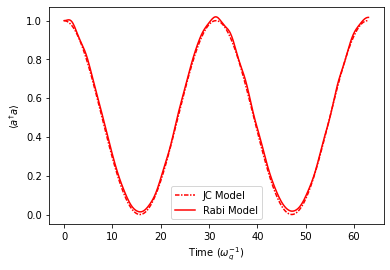

In [11]:
cavDimInd = 0
stepSizeInd = 0

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd], ResFid['nJC'][cavDimInd][stepSizeInd], linestyle=(0, (3, 1, 1, 1)), color='r', label='JC Model')
plt.plot(timePoints[stepSizeInd], ResFid['nRabi'][cavDimInd][stepSizeInd], linestyle='-', color='r', label='Rabi Model')
plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\langle a^{\dagger}a \rangle$")

Text(0, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

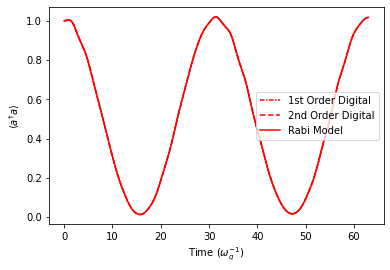

In [12]:
cavDimInd = 0
stepSizeInd = 0

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd], ResFid['nDig1'][cavDimInd][stepSizeInd], linestyle=(0, (3, 1, 1, 1)), color='r', label='1st Order Digital')
plt.plot(timePoints[stepSizeInd], ResFid['nDig2'][cavDimInd][stepSizeInd], linestyle='--', color='r', label='2nd Order Digital')
plt.plot(timePoints[stepSizeInd], ResFid['nRabi'][cavDimInd][stepSizeInd], linestyle='-', color='r', label='Rabi Model')

plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\langle a^{\dagger}a \rangle$")

Text(0, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

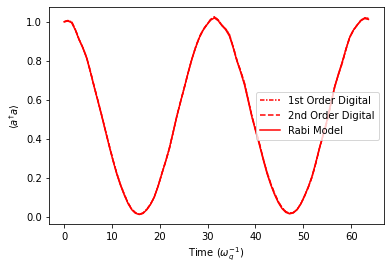

In [13]:
cavDimInd = 0
stepSizeInd = 0

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd+1], ResFid['nDig1'][cavDimInd][stepSizeInd+1], linestyle=(0, (3, 1, 1, 1)), color='r', label='1st Order Digital')
plt.plot(timePoints[stepSizeInd+1], ResFid['nDig2'][cavDimInd][stepSizeInd+1], linestyle='--', color='r', label='2nd Order Digital')
plt.plot(timePoints[stepSizeInd+1], ResFid['nRabi'][cavDimInd][stepSizeInd+1], linestyle='-', color='r', label='Rabi Model')

plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\langle a^{\dagger}a \rangle$")

Text(0, 0.5, '$\\mathcal{F}(\\psi_{dig}(t), \\psi_{Rabi}(t))$')

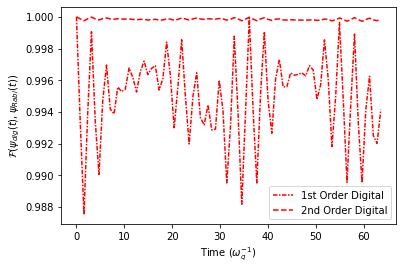

In [15]:
cavDimInd = 0
stepSizeInd = 0
markEvery = 50

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd+1], ResFid['fidDig1'][cavDimInd][stepSizeInd+1], linestyle=(0, (3, 1, 1, 1)), color='r', label='1st Order Digital')
plt.plot(timePoints[stepSizeInd+1], ResFid['fidDig2'][cavDimInd][stepSizeInd+1], linestyle='--', color='r', label='2nd Order Digital')

plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\mathcal{F}(\psi_{dig}(t), \psi_{Rabi}(t))$")

Text(0, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

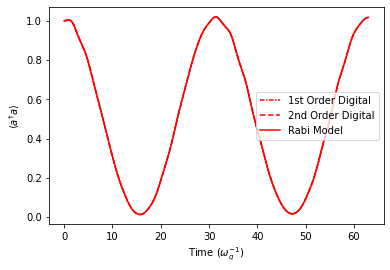

In [16]:
cavDimInd = 0
stepSizeInd = 0

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd], ResFid['nDig1'][cavDimInd][stepSizeInd], linestyle=(0, (3, 1, 1, 1)), color='r', label='1st Order Digital')
plt.plot(timePoints[stepSizeInd], ResFid['nDig2'][cavDimInd][stepSizeInd], linestyle='--', color='r', label='2nd Order Digital')
plt.plot(timePoints[stepSizeInd], ResFid['nRabi'][cavDimInd][stepSizeInd], linestyle='-', color='r', label='Rabi Model')

plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\langle a^{\dagger}a \rangle$")

Text(0, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

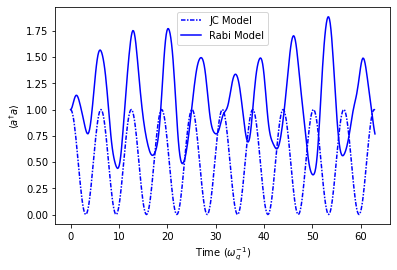

In [17]:
cavDimInd = 0
stepSizeInd = 0

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd], ResFid['nJC'][cavDimInd+1][stepSizeInd], linestyle=(0, (3, 1, 1, 1)), color='b', label='JC Model')
plt.plot(timePoints[stepSizeInd], ResFid['nRabi'][cavDimInd+1][stepSizeInd], linestyle='-', color='b', label='Rabi Model')

plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\langle a^{\dagger}a \rangle$")

Text(0, 0.5, '$\\langle a^{\\dagger}a \\rangle$')

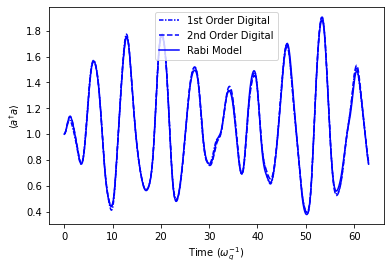

In [18]:
cavDimInd = 0
stepSizeInd = 0

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd], ResFid['nDig1'][cavDimInd+1][stepSizeInd], linestyle=(0, (3, 1, 1, 1)), color='b', label='1st Order Digital')
plt.plot(timePoints[stepSizeInd], ResFid['nDig2'][cavDimInd+1][stepSizeInd], linestyle='--', color='b', label='2nd Order Digital')
plt.plot(timePoints[stepSizeInd], ResFid['nRabi'][cavDimInd+1][stepSizeInd], linestyle='-', color='b', label='Rabi Model')

plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\langle a^{\dagger}a \rangle$")

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

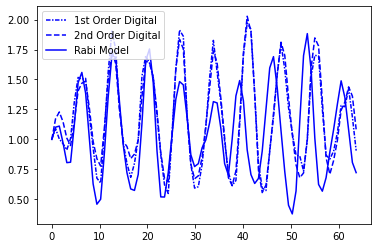

In [19]:
cavDimInd = 0
stepSizeInd = 0

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd+1], ResFid['nDig1'][cavDimInd+1][stepSizeInd+1], linestyle=(0, (3, 1, 1, 1)), color='b', label='1st Order Digital')
plt.plot(timePoints[stepSizeInd+1], ResFid['nDig2'][cavDimInd+1][stepSizeInd+1], linestyle='--', color='b', label='2nd Order Digital')
plt.plot(timePoints[stepSizeInd+1], ResFid['nRabi'][cavDimInd+1][stepSizeInd+1], linestyle='-', color='b', label='Rabi Model')

plt.legend()

plt.set_xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.set_ylabel(r"$\langle a^{\dagger}a \rangle$")

Text(0, 0.5, '$\\mathcal{F}(\\psi_{dig}(t), \\psi_{Rabi}(t))$')

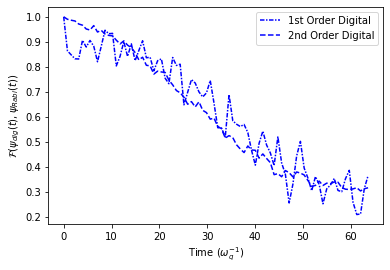

In [22]:
cavDimInd = 0
stepSizeInd = 0
markEvery = 50

ResFid = simulation.qRes.results

plt.plot(timePoints[stepSizeInd+1], ResFid['fidDig1'][cavDimInd+1][stepSizeInd+1], linestyle=(0, (3, 1, 1, 1)), color='b', label='1st Order Digital')
plt.plot(timePoints[stepSizeInd+1], ResFid['fidDig2'][cavDimInd+1][stepSizeInd+1], linestyle='--', color='b', label='2nd Order Digital')

plt.legend()

plt.xlabel(r"Time ($\omega_{q}^{-1}$)")
plt.ylabel(r"$\mathcal{F}(\psi_{dig}(t), \psi_{Rabi}(t))$")